In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil
import random

# Path ปัจจุบัน
source_dir = '/content/drive/MyDrive/RecyclableWasteDataset/datasetforcnn300pic'


base_output_dir = '/content/drive/MyDrive/RecyclableWasteDataset/splitforcnn300pic'
train_dir = os.path.join(base_output_dir, 'train')
test_dir = os.path.join(base_output_dir, 'test')


train_split = 0.9

def split_dataset():
    if not os.path.exists(train_dir): os.makedirs(train_dir)
    if not os.path.exists(test_dir): os.makedirs(test_dir)

    for class_name in sorted(os.listdir(source_dir)):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        train_count = int(len(images) * train_split)

        train_images = images[:train_count]
        test_images = images[train_count:]


        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

        print(f"{class_name}: {len(train_images)} train | {len(test_images)} test")


split_dataset()


glass: 270 train | 30 test
metal: 270 train | 30 test
paper: 270 train | 30 test
plastic: 270 train | 30 test


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# เตรียม train / validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 864 images belonging to 4 classes.
Found 216 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = train_generator.num_classes

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 883ms/step - accuracy: 0.2514 - loss: 2.2942 - val_accuracy: 0.3611 - val_loss: 1.3465
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 803ms/step - accuracy: 0.3069 - loss: 1.3434 - val_accuracy: 0.4907 - val_loss: 1.2844
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 744ms/step - accuracy: 0.3996 - loss: 1.3062 - val_accuracy: 0.4444 - val_loss: 1.2409
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 818ms/step - accuracy: 0.4175 - loss: 1.2441 - val_accuracy: 0.5370 - val_loss: 1.1656
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 749ms/step - accuracy: 0.4976 - loss: 1.2006 - val_accuracy: 0.5278 - val_loss: 1.1729
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5073 - loss: 1.1813 - val_accuracy: 0.4861 - val_loss: 1.1669
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 844ms/step - accuracy: 0.5028 - loss: 1.1584 - val_accuracy: 0.5278 - val_loss: 1.1242
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 864ms/step - accuracy: 0.4857 - loss: 1.1928 - val_accurac

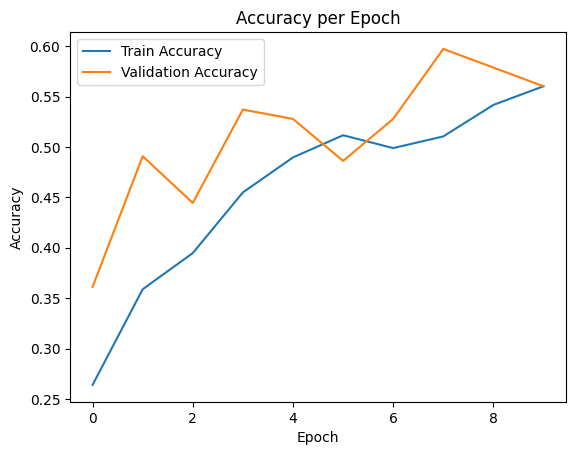

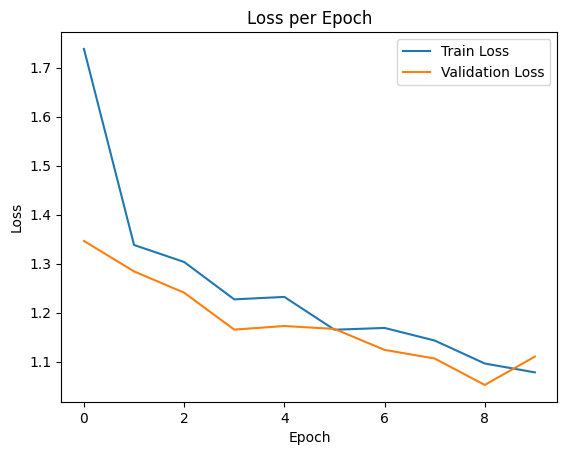

In [ ]:
import matplotlib.pyplot as plt

# กราฟaccuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

# กราฟloss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.4610 - loss: 1.1159
Test Accuracy: 0.48
Test Loss: 1.13


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step


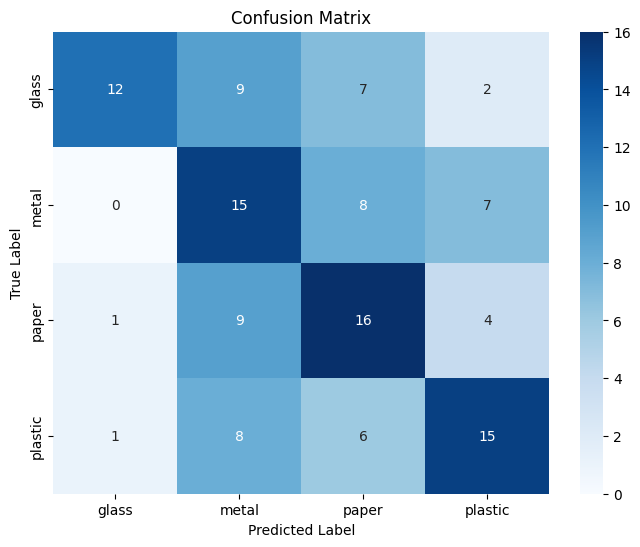


Classification Report:
              precision    recall  f1-score   support

       glass       0.86      0.40      0.55        30
       metal       0.37      0.50      0.42        30
       paper       0.43      0.53      0.48        30
     plastic       0.54      0.50      0.52        30

    accuracy                           0.48       120
   macro avg       0.55      0.48      0.49       120
weighted avg       0.55      0.48      0.49       120



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


จำนวนภาพที่ทำนายผิด: 62


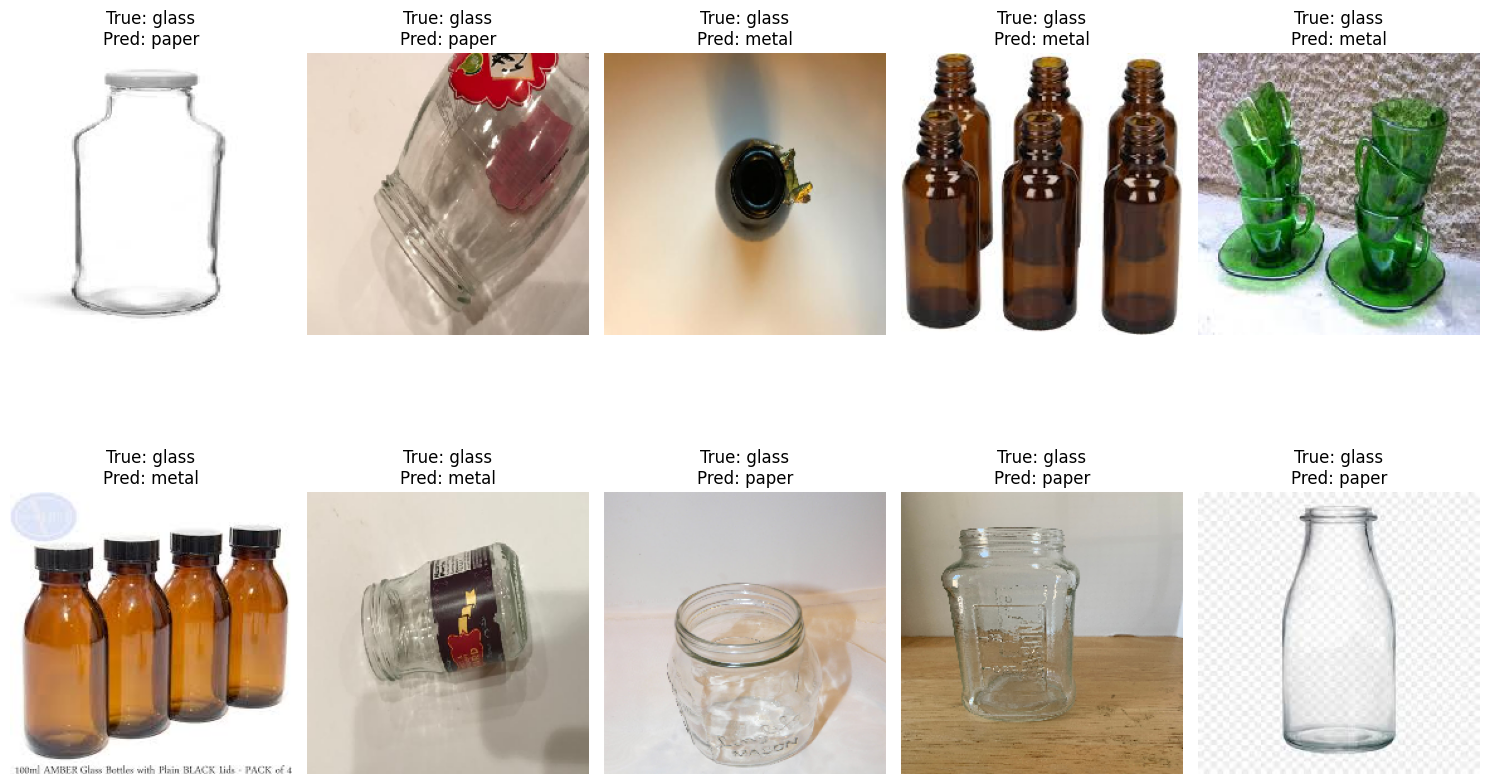

In [ ]:
import matplotlib.pyplot as plt
#ดูภาพที่ทำนายผิด

X_test, _ = next(test_generator)
for i in range(1, test_generator.__len__()):
    x, _ = next(test_generator)
    X_test = np.concatenate((X_test, x), axis=0)

misclassified_indices = np.where(y_pred != y_true)[0]

print(f"จำนวนภาพที่ทำนายผิด: {len(misclassified_indices)}")

# แสดงภาพที่ทำนายผิด 10 ภาพแรก
num_images_to_show = min(10, len(misclassified_indices))
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:num_images_to_show]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Saving Screenshot 2025-05-23 030013.png to Screenshot 2025-05-23 030013 (2).png
Saving Screenshot 2025-05-23 030000.png to Screenshot 2025-05-23 030000 (2).png
Saving Screenshot 2025-05-23 025950.png to Screenshot 2025-05-23 025950 (2).png
Saving Screenshot 2025-05-23 025908.png to Screenshot 2025-05-23 025908 (2).png
Saving Screenshot 2025-05-23 025856.png to Screenshot 2025-05-23 025856 (2).png
Saving Screenshot 2025-05-23 025755.png to Screenshot 2025-05-23 025755 (2).png
Saving Screenshot 2025-05-23 025747.png to Screenshot 2025-05-23 025747 (2).png
Saving Screenshot 2025-05-23 025736.png to Screenshot 2025-05-23 025736 (2).png
Saving Screenshot 2025-05-23 025725.png to Screenshot 2025-05-23 025725 (2).png
Saving Screenshot 2025-05-23 025716.png to Screenshot 2025-05-23 025716 (2).png
Saving Screenshot 2025-05-23 025707.png to Screenshot 2025-05-23 025707 (2).png
Saving Screenshot 2025-05-23 025644.png to Screenshot 2025-05-23 025644 (2).png
Saving Screenshot 2025-05-23 025633.png 

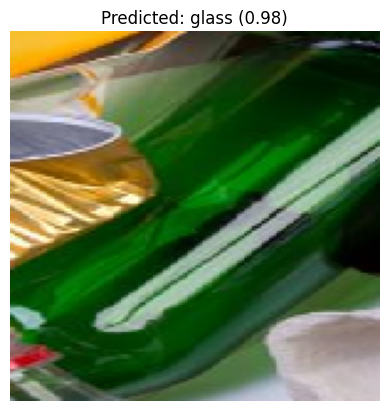

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


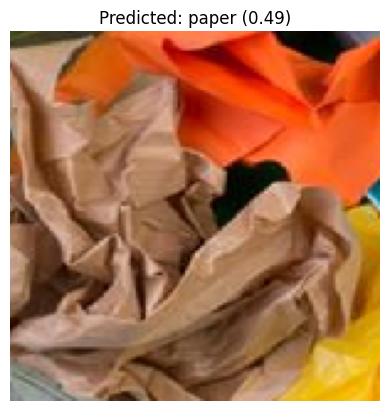

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


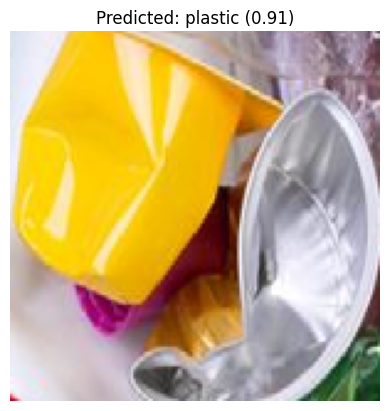

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


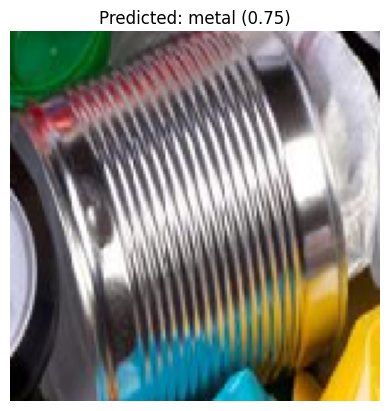

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


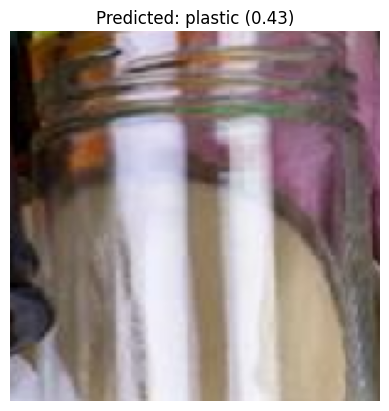

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


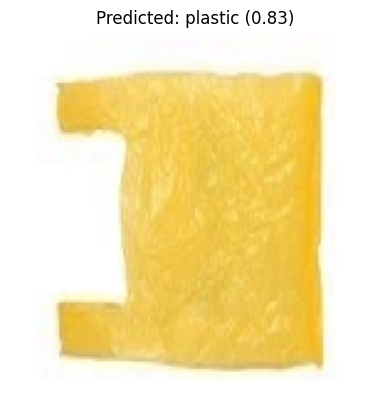

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


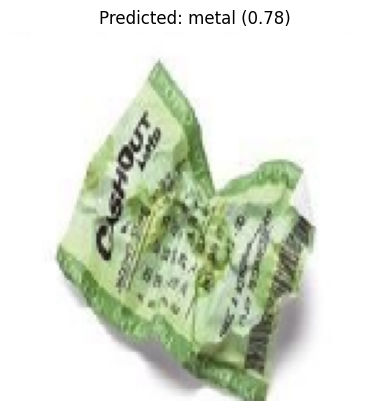

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


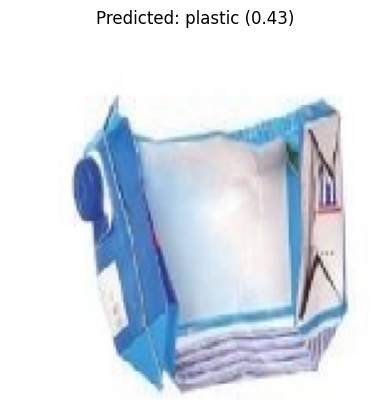

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


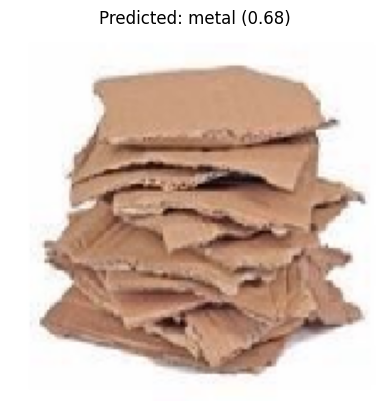

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


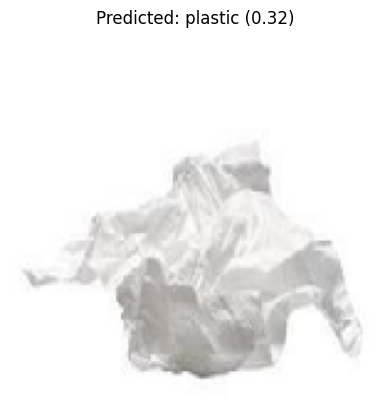

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


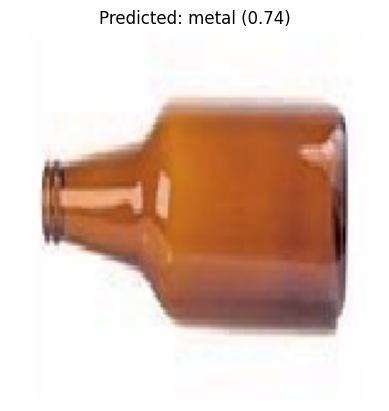

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


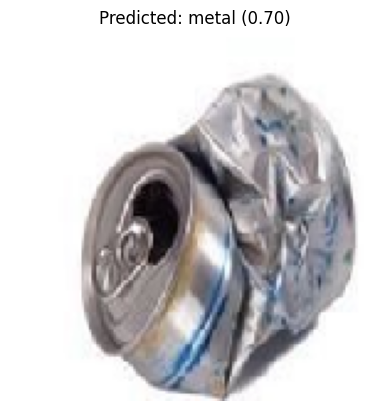

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


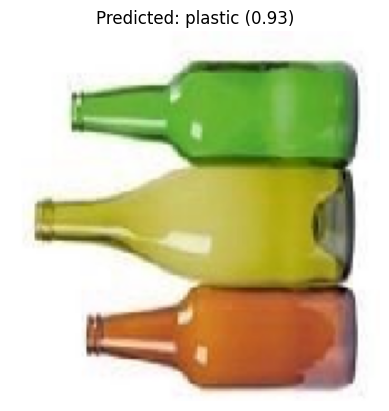

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


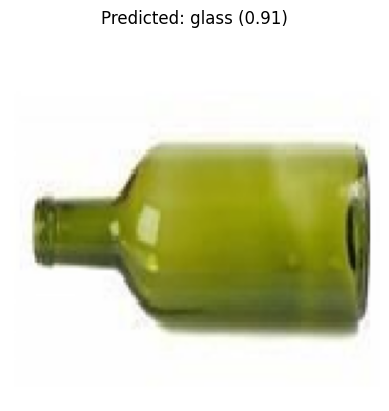

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


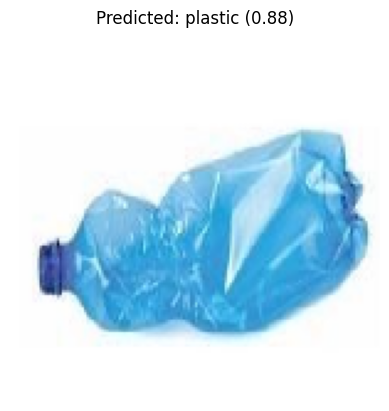

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
#ทดสอบรูปภาพนอก dataset ชุดเดียวกับ yolo
# อัปโหลดหลายไฟล์จากเครื่อง
uploaded = files.upload()

class_labels = list(train_generator.class_indices.keys())


for img_path in uploaded.keys():

    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # ทำนาย
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = class_labels[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    # แสดงภาพและผลลัพธ์
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} ({confidence:.2f})')
    plt.axis('off')
    plt.show()
